In [46]:
#!pip install tensorflow-text
#!pip install tf-models-official
#!pip install tensorflow-hub 
#!pip install pandas 
#!pip install transformers

import os
import shutil

import tensorflow as tf
from nltk.stem.porter import PorterStemmer
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import pandas as pd 
import re
import nltk 
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
import matplotlib.pyplot as plt

#train models 
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import seaborn as sn
import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')
nltk.download('stopwords')

     |████████████████████████████████| 2.3MB 32.4MB/s 
     |████████████████████████████████| 3.3MB 38.5MB/s 
     |████████████████████████████████| 901kB 42.1MB/s 
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Loading data

In [19]:
from google.colab import drive
drive.mount('/content/drive')
train = pd.read_csv('/content/drive/Shareddrives/Trabalho IART/Trabalho 2/code/data/test.csv')
test = pd.read_csv('/content/drive/Shareddrives/Trabalho IART/Trabalho 2/code/data/test.csv')
train.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,ID,TITLE,ABSTRACT
0,20973,Closed-form Marginal Likelihood in Gamma-Poiss...,We present novel understandings of the Gamma...
1,20974,Laboratory mid-IR spectra of equilibrated and ...,Meteorites contain minerals from Solar Syste...
2,20975,Case For Static AMSDU Aggregation in WLANs,Frame aggregation is a mechanism by which mu...
3,20976,The $Gaia$-ESO Survey: the inner disk intermed...,Milky Way open clusters are very diverse in ...
4,20977,Witness-Functions versus Interpretation-Functi...,Proving that a cryptographic protocol is cor...


# Clean text

In [48]:
def normalize(df): 
    corpus = []
    ps = PorterStemmer()
    df_size = len(df) 
    for i in range(0,df_size):
        # get review and remove non alpha chars
        article = re.sub('[^a-zA-Z]', ' ', df['ABSTRACT'][i])
        # to lower-case and tokenize
        article = article.lower().split()
        # stemming and stop word removal
        article = ' '.join([ps.stem(w) for w in article if not w in set(stopwords.words('english'))])
        corpus.append(article)
    return corpus

# To avoid making this cleaning every time, we save teh output as a csv
def save_csv(corpus_train, file_name): 
    df = pd.DataFrame({'text': corpus_train})
    df.to_csv(file_name) 
    
train['ABSTRACT'] = train['TITLE'] +train['ABSTRACT']
corpus_train = normalize(train)

test['ABSTRACT'] = test['TITLE'] + test['ABSTRACT']
corpus_test = normalize(test)


# Preprocess text
Before preprocessing let's take a look on the size of the texts.

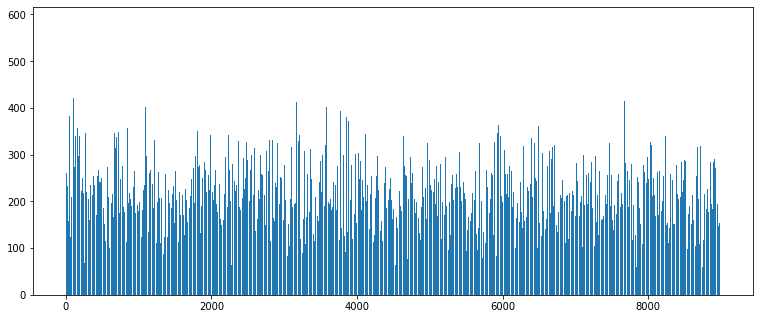

In [37]:
# if there's a text really large, we might cut it's size 
len_abstract = [len(i.split(' ')) for i in train['ABSTRACT']]
len_title = [len(i.split(' ')) for i in train['TITLE']]
len_text = [len_title[i] + len_abstract[i] for i in range(len(train))]
x = [i for i in range(len(train))]

fig = plt.figure(figsize=(10, 4))
ax = fig.add_axes([0,0,1,1])
ax.bar(x, sortlen_text)
plt.show()

What's the media? 


In [42]:
len_text = np.array(len_text)
print("media", np.median(len_text))
print("max", np.max(len_text))
print("min", np.min(len_text))
MAX_SIZE = 250

media 211.0
max 587
min 29


In [55]:
# https://towardsdatascience.com/bert-to-the-rescue-17671379687f
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
encodings = tokenizer.batch_encode_plus(corpus_train,max_length=MAX_SIZE,pad_to_max_length=True,truncation=True, return_token_type_ids=True)
# encodings is Batch Encoding: https://huggingface.co/transformers/main_classes/tokenizer.html#transformers.BatchEncoding

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [56]:
print(encodings.keys())
print("input_ids", encodings['input_ids'][0])
# List of token type ids to be fed to a model 
print("token_types_ids", encodings['token_type_ids'][0])
# List of indices specifying which tokens should be attended to by the model
print("attention_mask", encodings['attention_mask'][0])


dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
input_ids [101, 2485, 2433, 7785, 16593, 13091, 13433, 24077, 8185, 5387, 3989, 20464, 2891, 2433, 7785, 16593, 13091, 13433, 24077, 8185, 5387, 3989, 20464, 2891, 2433, 7785, 16593, 13091, 13433, 24077, 8185, 5387, 3989, 20464, 2891, 2433, 7785, 16593, 13091, 13433, 24077, 8185, 5387, 3989, 20464, 2891, 2433, 7785, 16593, 13091, 13433, 24077, 8185, 5387, 3989, 20464, 2891, 2433, 7785, 16593, 13091, 13433, 24077, 8185, 5387, 3989, 20464, 2891, 2433, 7785, 16593, 13091, 13433, 24077, 8185, 5387, 3989, 20464, 2891, 2433, 7785, 16593, 13091, 13433, 24077, 8185, 5387, 3989, 20464, 2891, 2433, 7785, 16593, 13091, 13433, 24077, 8185, 5387, 2556, 3117, 3305, 13091, 13433, 24077, 6578, 2944, 4013, 3676, 27965, 2102, 8185, 5387, 2944, 4175, 2951, 2265, 6578, 2128, 15773, 2489, 3556, 2552, 12848, 8185, 2507, 2149, 2047, 12369, 9765, 5714, 8476, 4487, 7542, 8486, 8185, 4555, 7785, 16593, 9765, 5714, 3327, 4863, 15873, 9765, 5714, 28699,

# Loading BERT

In [21]:
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/v3/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

# Get BERT model